In [61]:
import pandas as pd
import numpy as np
import matplotlib as plt
# redshift connection #
import sqlalchemy
import psycopg2
import pyodbc
import simplejson
from flask_sqlalchemy import SQLAlchemy
%load_ext sql
%config SqlMagic.displaylimit = 5
from datetime import datetime, timedelta

# stats #
from scipy import stats as sp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# viz #
from IPython.display import HTML
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from plotly import tools
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
with open("cred_location") as fh:
    creds = simplejson.loads(fh.read())
redshift = 'postgresql+psycopg2://' + \
                creds['user_name'] + ':' + creds['password'] + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

In [5]:
with open("cred_location") as hm:
    credz = simplejson.loads(hm.read())
azure = pyodbc.connect(
    r'DRIVER={ODBC Driver 11 for SQL Server};'
    r'SERVER='+credz['host_name']+';'
    r'DATABASE='+credz['db_name']+';'
    r'UID='+credz['user_name']+';'
    r'PWD='+credz['password']
)

In [3]:
SQL1 = """input query here""""

In [10]:
SQL2 = """anotherqueryhere"""

## Train/Test Split ##

Using np.random, we split into 70% train/30% test.

In [41]:
msk = np.random.rand(len(true_adopters)) < 0.7

train = true_adopters[msk]
test = true_adopters[~msk]

x_train_ = train.drop(columns=['adoptionRate','highadoptionrate'])
x_test_ = test.drop(columns=['adoptionRate','highadoptionrate'])
x_train_,x_test_=x_train_.fillna(0),x_test_.fillna(0)
y_train = train[['adoptionRate']]
y_test = test[['adoptionRate']]
y_train_down = train[['adoptionRate']]
y_test_down = test[['adoptionRate']]
print(len(x_train_))
print(len(x_test_))

16202
6912


## Scale Data using the StandardScaler ##

In [ ]:
stdsc = StandardScaler()
x_train = stdsc.fit_transform(x_train_)
x_test = stdsc.fit_transform(x_test_)
x_train = pd.DataFrame(data = x_train, columns = x_train_.columns,index=x_train_.index)
x_test = pd.DataFrame(data = x_test, columns = x_test_.columns,index=x_test_.index)

## Plot Correlation Matrix on Scaled Features ##

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(train.corr())
fig.colorbar(cax)

train.corr(method='pearson')

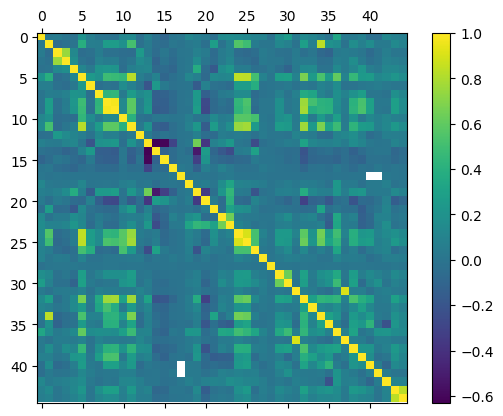

In [44]:
fig

## Using Recursive Feature Elimination to Feature Selection ##
Paring down to 12 features (manually determined this level, in future could include in pipeline/gridsearch).

In [70]:
y_train = np.ravel(y_train)
rfr = RandomForestRegressor()
rfe = RFE(rfr,n_features_to_select=12)
rfe = rfe.fit(x_train,y_train)
print(rfe.support_)
print(rfe.ranking_)
keep = rfe.support_

[ True False False False False  True False False  True  True False  True
 False False False False False False False False False False False False
  True  True  True False False False  True False False False  True False
 False False False  True False False  True]
[ 1  6 13 10 26  1 15  3  1  1  4  1 18 23 22 21 28 32 29 30 19 25 24 12
  1  1  1 16 31 14  1 27  5  7  1 17  8 20  2  1  9 11  1]


### Keep only those features identified above ###

In [ ]:
columns = pd.DataFrame(
    {'columnname': x_train.columns.values,
     'include': keep})
columns_keep = columns[columns['include']==True]
columns_keep = columns_keep.columnname.values
x_train1 = x_train[columns_keep]
x_test1 = x_test[columns_keep]

## Fit Random Forest Regressor ##

In [72]:
rfr = RandomForestRegressor(100).fit(x_train1, y_train)

In [73]:
yhat = rfr.predict(x_train1)

x_train1['predicted_adoption']=yhat
x_train1['actual_adoption']=y_train

In [74]:
predict_adopt = rfr.predict(x_test1)

x_test1['predicted_adoption']=predict_adopt
x_test1['actual_adoption']=y_test

In [75]:
def mean_absolute_percentage_error(y_test, predict_adopt):
    y_test, predict_adopt = np.array(y_test), np.array(predict_adopt)
    return np.mean(np.abs((y_test - predict_adopt) / y_test)) * 100

In [76]:
print('test MAPE ' + str(mean_absolute_percentage_error(y_test, predict_adopt)))
print('vs train MAPE (check for overfitting) ' + str(mean_absolute_percentage_error(y_train, yhat)))

test MAPE 10.458003285938931
vs train MAPE (check for overfitting) 2.5278681422436304


## Visualize Performance on Test Group ##

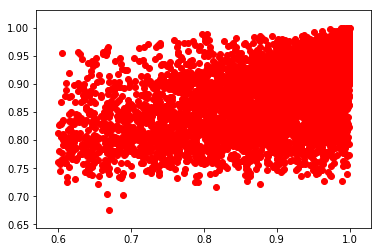

In [77]:
plt.scatter(y_test, predict_adopt, color='red',linewidth=1)

In [83]:
entire_pop = total_population.drop(columns=['adoptionRate','highadoptionrate']).fillna(0)

entire_pop = entire_pop[columns_keep]
entire_pop_ = stdsc.fit_transform(entire_pop)
entire_pop = pd.DataFrame(data = entire_pop_, columns = entire_pop.columns,index=entire_pop.index)

pop_predict = rfr.predict(entire_pop)

entire_pop['predicted_adoption']=pop_predict
entire_pop['actual_adoption']=total_population['adoptionRate']

## Now, Apply to Population to Estimation Product Usage Threshold ##

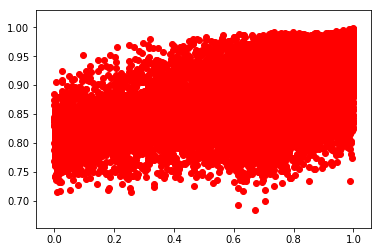

In [84]:
plt.scatter(entire_pop['actual_adoption'], pop_predict, color='red',linewidth=1)

In [91]:
init_notebook_mode(connected=True)

# Train #
e1 = pop_predict
e2 = yhat

hhist_data = [e1,e2]
ggroup_labels = ['Population','Training Set']
colorss = ['#cc6649','#40e0d0']
eeldisto = ff.create_distplot(hhist_data, ggroup_labels, bin_size=.025, colors=colorss, show_rug=False)
eeldisto['layout'].update(title='Production Adoption Threshold| RFR Assigned Probabilities'
                         ,titlefont=dict(size=24, color='#3e3838')
                         ,legend=dict(x=.8,y=1,
                                     bgcolor='#E2E2E2')
                         ,xaxis=dict(title="Prediction Adoption Rates",
                                     position=-0.4,
                                     titlefont=dict(size=18, color='#3e3838'),
                                    showgrid=True)
                        ,yaxis=dict(title="% of Customers",
                                    showgrid=True,
                                    showline=False,
                                    ticks='',
                                    showticklabels=False))
print(po.iplot(eeldisto,show_link=False,filename = 'adopt_predict_probs.html'))

None


In [6]:
from IPython.display import Image

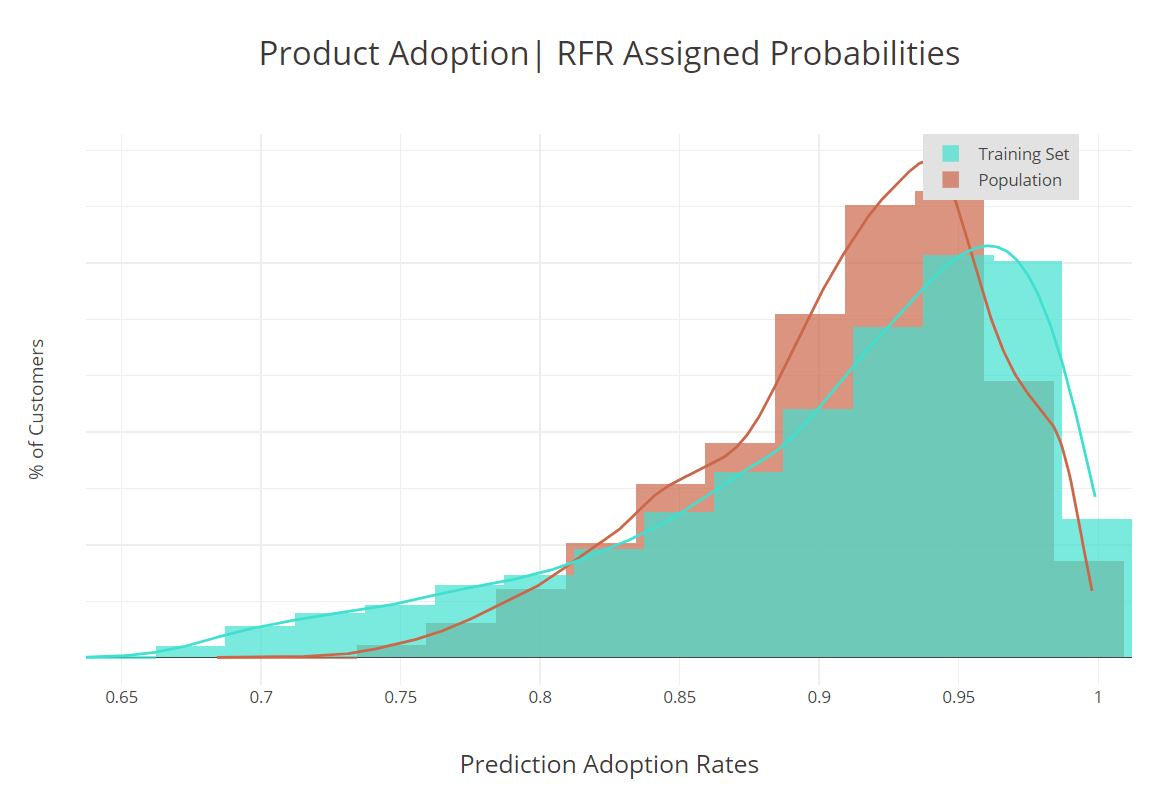

In [8]:
Image(filename='./prod_usage_viz.jpg', width=00)